In [1]:
import numpy as npp
import minpy.numpy as np
import cPickle
import matplotlib.pyplot as plt
import minpy
minpy.set_global_policy('only_numpy')

from SimplePolicyNetwork import SimplePolicyNetwork
from SimpleRLPolicyGradientSolver import SimpleRLPolicyGradientSolver
from simpleBox import simpleBox
from SimRat import SimRat
from dataProcessFunctions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Episode 50 complete (0.02s), loss: 20.425313293, reward: 3, running reward: -2.24336767203
Episode 100 complete (0.01s), loss: 16.5838742909, reward: 1, running reward: -1.39758492108
Episode 150 complete (0.01s), loss: 15.0297972629, reward: -3, running reward: -0.826556824377
Episode 200 complete (0.01s), loss: 9.78446236924, reward: 5, running reward: -0.0181549015086
Episode 250 complete (0.01s), loss: 4.82360401386, reward: 3, running reward: 1.07753416943
Episode 300 complete (0.01s), loss: 1.50187750733, reward: 1, running reward: 1.99149290969
Episode 350 complete (0.01s), loss: 0.349815126221, reward: 5, running reward: 3.05853572552
Episode 400 complete (0.01s), loss: 0.0750555894542, reward: 5, running reward: 3.81188775383
Episode 450 complete (0.02s), loss: 0.0326453482942, reward: 5, running reward: 4.28118488262
Episode 500 complete (0.01s), loss: 0.0170844689288, reward: 5, running reward: 4.56511249284


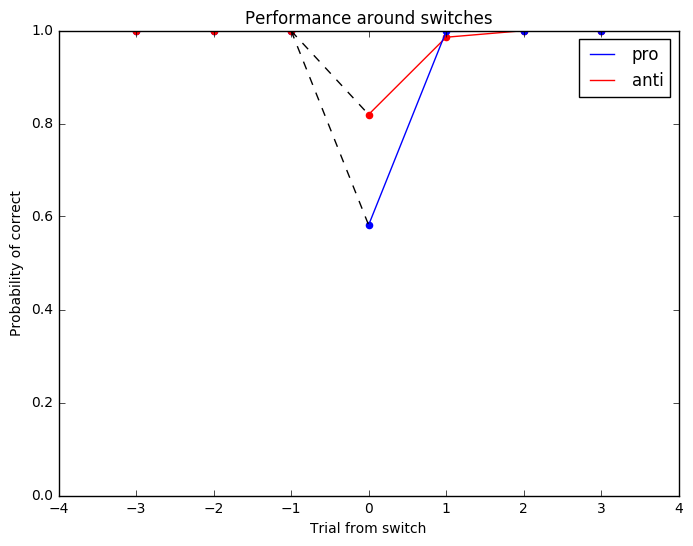

/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


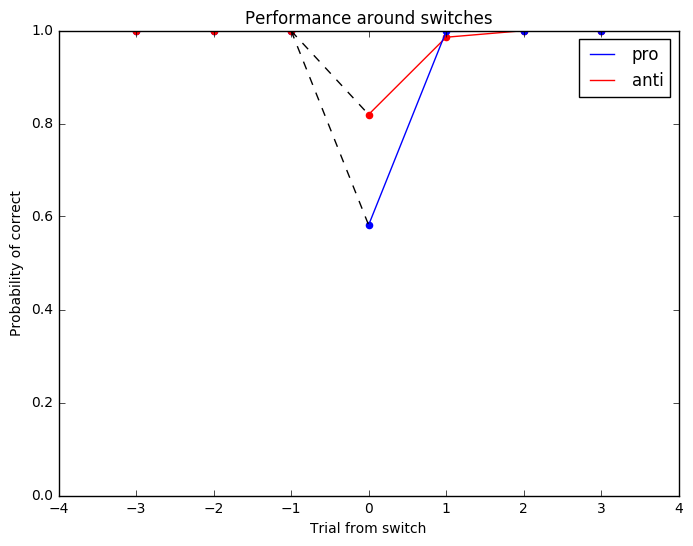

dataProcessFunctions.py:415: RuntimeWarning: Mean of empty slice
  pro_mean = np.nanmean(pro_matrix, axis = 0)
dataProcessFunctions.py:416: RuntimeWarning: Mean of empty slice
  anti_mean = np.nanmean(anti_matrix, axis = 0)


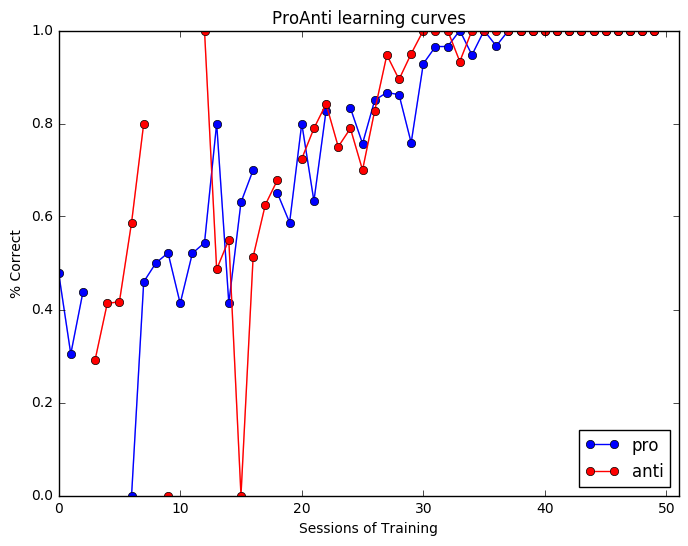

In [2]:
box = simpleBox(mode="alternative",length=1000,block_size=30,random_range=0,trial_per_episode=5, repeat = True)
val_X, val_y = box.X,box.y
rats = {}
for i in range(1):
    ratname = 'VirtualRat'+str(i)
    model = SimplePolicyNetwork(hidden_dim=5,reg=0, noise_factor = 0)
    rat = SimRat(model)
    box = simpleBox(mode="alternative",length=10000,block_size=30,random_range=0,
                    trial_per_episode=5, repeat = True, reward_ratio = 1, p2a = 0.5, correction = True)
    solver = SimpleRLPolicyGradientSolver(model, box,
                                        update_rule='adam',
                                        optim_config={
                                            'learning_rate': 0.01,
                                            'decay_rate': 1
                                        },
                                        init_rule='xavier',
                                        num_episodes=501,
                                        verbose=False,
                                        supervised = True,
                                        stop = False,
                                        print_every=50)
    solver.init()
    solver.set_temperature(5)
    #init_param = solver.save_params()
    #solver.load_params(loaded_params)
    solver.train()
    
    probs = rat.predict(val_X,val_y)
    trial_window = 3
    np.set_printoptions(precision=2)
    plt.ylim([0,1])
    draw_3d(rat.p2a_prob, rat.a2p_prob, trial_window = 3)

    rats[ratname] = rat
    #params[ratname] = init_param
    rat.addHistory(box.output_history())
    rat.computeLearningCurve(50)

trial_window = 3
p2a_mean, a2p_mean = meanPerformance(rats, trial_window = 3)
np.set_printoptions(precision=2)
plt.ylim([0,1])
draw_3d(p2a_mean, a2p_mean, trial_window = 3)
pro_mean, anti_mean = meanLearningCurve(rats)
learningCurve(pro_mean,anti_mean, rats)

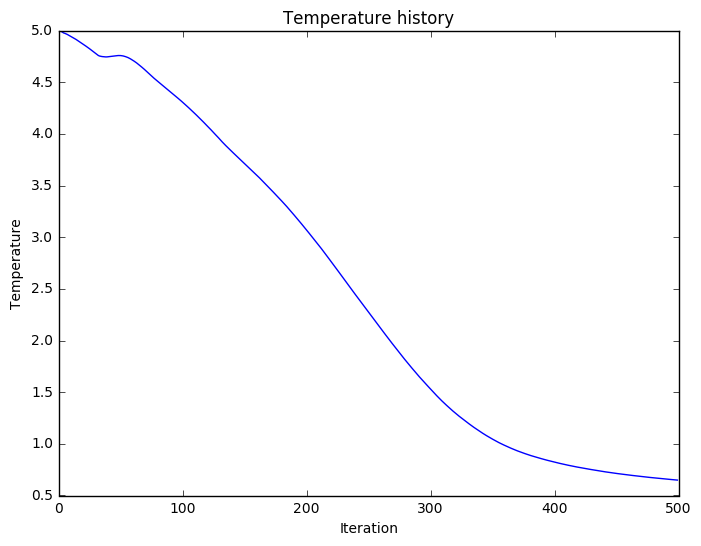

In [3]:
plt.plot(solver.temperature_history)
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.title('Temperature history')
plt.show()

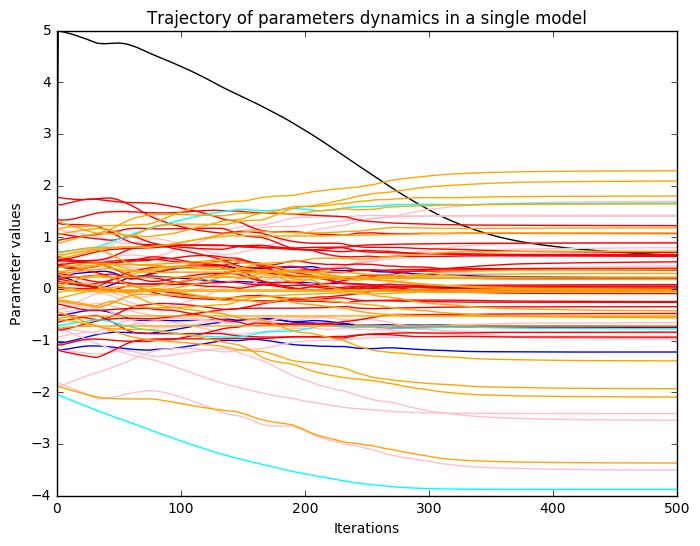

In [7]:
def single_model_parameter_trajectory(parameter_history):
    params2color = {"b":"blue","temperature":"black","Wa":"pink","Wh":"red","ba":"cyan","Wx":"orange"}
    for k, vv in parameter_history.iteritems():
        v = vv.asnumpy()
        if len(v.shape)==1:
            plt.plot(np.arange(v.shape[0]),v[:],color=params2color[k])
        elif len(v.shape)==2:
            for i in range(v.shape[1]):
                plt.plot(np.arange(v.shape[0]),v[:,i],color=params2color[k])
        elif len(v.shape)==3:
            for i in range(v.shape[1]):
                for j in range(v.shape[2]):
                    plt.plot(np.arange(v.shape[0]),v[:,i,j],color=params2color[k])   
    
    plt.title("Trajectory of parameters dynamics in a single model")
    plt.xlabel("Iterations")
    plt.ylabel("Parameter values")

    plt.show()
single_model_parameter_trajectory(solver.parameter_history)